<a href="https://colab.research.google.com/github/dbasrai/watchmyset/blob/master/WMS_predict_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install pydub numpy scipy matplotlib ipython jupyter pandas sympy nose tqdm python_speech_features
from pydub import AudioSegment
from pydub.utils import make_chunks
import os
import ntpath
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank

def gen_chunks(audio_filename, output_folder):
  myaudio = AudioSegment.from_file(audio_filename) 
  chunk_length_ms = 1000 # pydub calculates in millisec
  chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec
  chunk_list = []

  base_filename = ntpath.basename(audio_filename)

  if len(base_filename) > 7:
    vid_title = base_filename[0:6]
  else:
    vid_title = base_filename

  #Export all of the individual chunks as wav files

  for i, chunk in enumerate(chunks):
      chunk_name = f"{vid_title}chunk{i}.wav"
      print ("exporting", chunk_name)
      chunk.export(f'{output_folder}/{chunk_name}', format="wav")
      chunk_list.append(chunk_name)
  
  chunk_list.pop()

  return vid_title, chunk_list

def delete_path(path):
  for root, dirs, files in os.walk(path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))

     |████████████████████████████████| 163kB 9.6MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=15556601a8508b59290f59d12f1ba72bbf41718df51026d0d89342623b0cf7ce
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
!pip install youtube_dl
from __future__ import unicode_literals
import youtube_dl
import os

output_path = '/content/gdrive/My Drive/Colab Notebooks/youtube_dl_wav'
chunk_path = '/content/gdrive/My Drive/Colab Notebooks/chunks'
yt_url = 'https://www.youtube.com/watch?v=bCoJduAhbgs'

ydl_opts = {
    'outtmpl': os.path.join(output_path, '%(title)s-%(id)s.%(ext)s'),
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192'
    }],
    'postprocessor_args': [
        '-ar', '16000'
    ],
    'prefer_ffmpeg': True,
    'keepvideo': True
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
  ydl.download([yt_url])

for filename in os.listdir(output_path):
    if filename.endswith(".wav"):
      title, chunkname_list = gen_chunks(f'{output_path}/{filename}', chunk_path)

delete_path(output_path)

    

     |████████████████████████████████| 1.8MB 9.4MB/s 
[youtube] bCoJduAhbgs: Downloading webpage
[download] Destination: /content/gdrive/My Drive/Colab Notebooks/youtube_dl_wav/Mark Normand Stand-Up-bCoJduAhbgs.webm
[download] 100% of 5.22MiB in 00:00
[ffmpeg] Destination: /content/gdrive/My Drive/Colab Notebooks/youtube_dl_wav/Mark Normand Stand-Up-bCoJduAhbgs.wav
exporting Mark Nchunk0.wav
exporting Mark Nchunk1.wav
exporting Mark Nchunk2.wav
exporting Mark Nchunk3.wav
exporting Mark Nchunk4.wav
exporting Mark Nchunk5.wav
exporting Mark Nchunk6.wav
exporting Mark Nchunk7.wav
exporting Mark Nchunk8.wav
exporting Mark Nchunk9.wav
exporting Mark Nchunk10.wav
exporting Mark Nchunk11.wav
exporting Mark Nchunk12.wav
exporting Mark Nchunk13.wav
exporting Mark Nchunk14.wav
exporting Mark Nchunk15.wav
exporting Mark Nchunk16.wav
exporting Mark Nchunk17.wav
exporting Mark Nchunk18.wav
exporting Mark Nchunk19.wav
exporting Mark Nchunk20.wav
exporting Mark Nchunk21.wav
exporting Mark Nchunk22.w

In [4]:
import librosa
from keras.models import load_model
from sklearn.metrics import accuracy_score

X_pred_list = []
_min, _max = float('inf'), -float('inf')

model_name = 'WMS_model_5.5k.model'
model = load_model(f'/content/gdrive/My Drive/Colab Notebooks/models/{model_name}')

for i in tqdm(chunkname_list):
  signal, rate = librosa.load(f'{chunk_path}/{i}', sr=16000)
  mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=512)
  X_pred_list.append(mel)
  _min = min(np.amin(X_pred_list), _min)
  _max = max(np.amax(X_pred_list), _max)

X_pred = np.array(X_pred_list)
X_pred = (X_pred - _min) / (_max - _min)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], X_pred.shape[2])

y_pred = model.predict(X_pred)

y_guess = np.argmax(y_pred, axis=1)

np.savetxt(f"/content/gdrive/My Drive/Colab Notebooks/predictions/{model_name}_{title}_csv_predict.csv", y_guess, delimiter=",")
np.savetxt(f"/content/gdrive/My Drive/Colab Notebooks/predictions/{model_name}_{title}_csv_probability.csv", y_pred, delimiter=",")



Using TensorFlow backend.
100%|██████████| 339/339 [00:40<00:00,  8.34it/s]


In [0]:
import math as math
from matplotlib.pyplot import step, show
import matplotlib.pyplot as plt

numLaughter = np.count_nonzero(y_guess)
laughPercent =  round((numLaughter / y_guess.size) * 100, 1)
laughTimes = []
laughTimesList = []
numLaughs = 0
check = 0

for i in tqdm(range(y_guess.size)):
  if (y_guess[i]==1 and check==0):
    numLaughs=numLaughs+1
    check = 1
    laughTimes.append(i)
  else:
    check = y_guess[i]

for i in tqdm(range(len(laughTimes))):
  seconds = np.mod(laughTimes[i], 60)
  minutes = np.floor_divide(laughTimes[i], 60)
  laughTimesList.append('{0} minutes '.format(minutes) + 'and {0} seconds'.format(seconds))

laughsPerMin = numLaughs / (y_guess.size/60)

print('\n{0} stats'.format(title))
print('Laugh Percentage = {0}%'.format(laughPercent))
print('Num Laughs = {0}'.format(numLaughs))
print('Laughs Per Minute (LPM) = {0}'.format(round(laughsPerMin, 1)))
print("\n".join(laughTimesList))


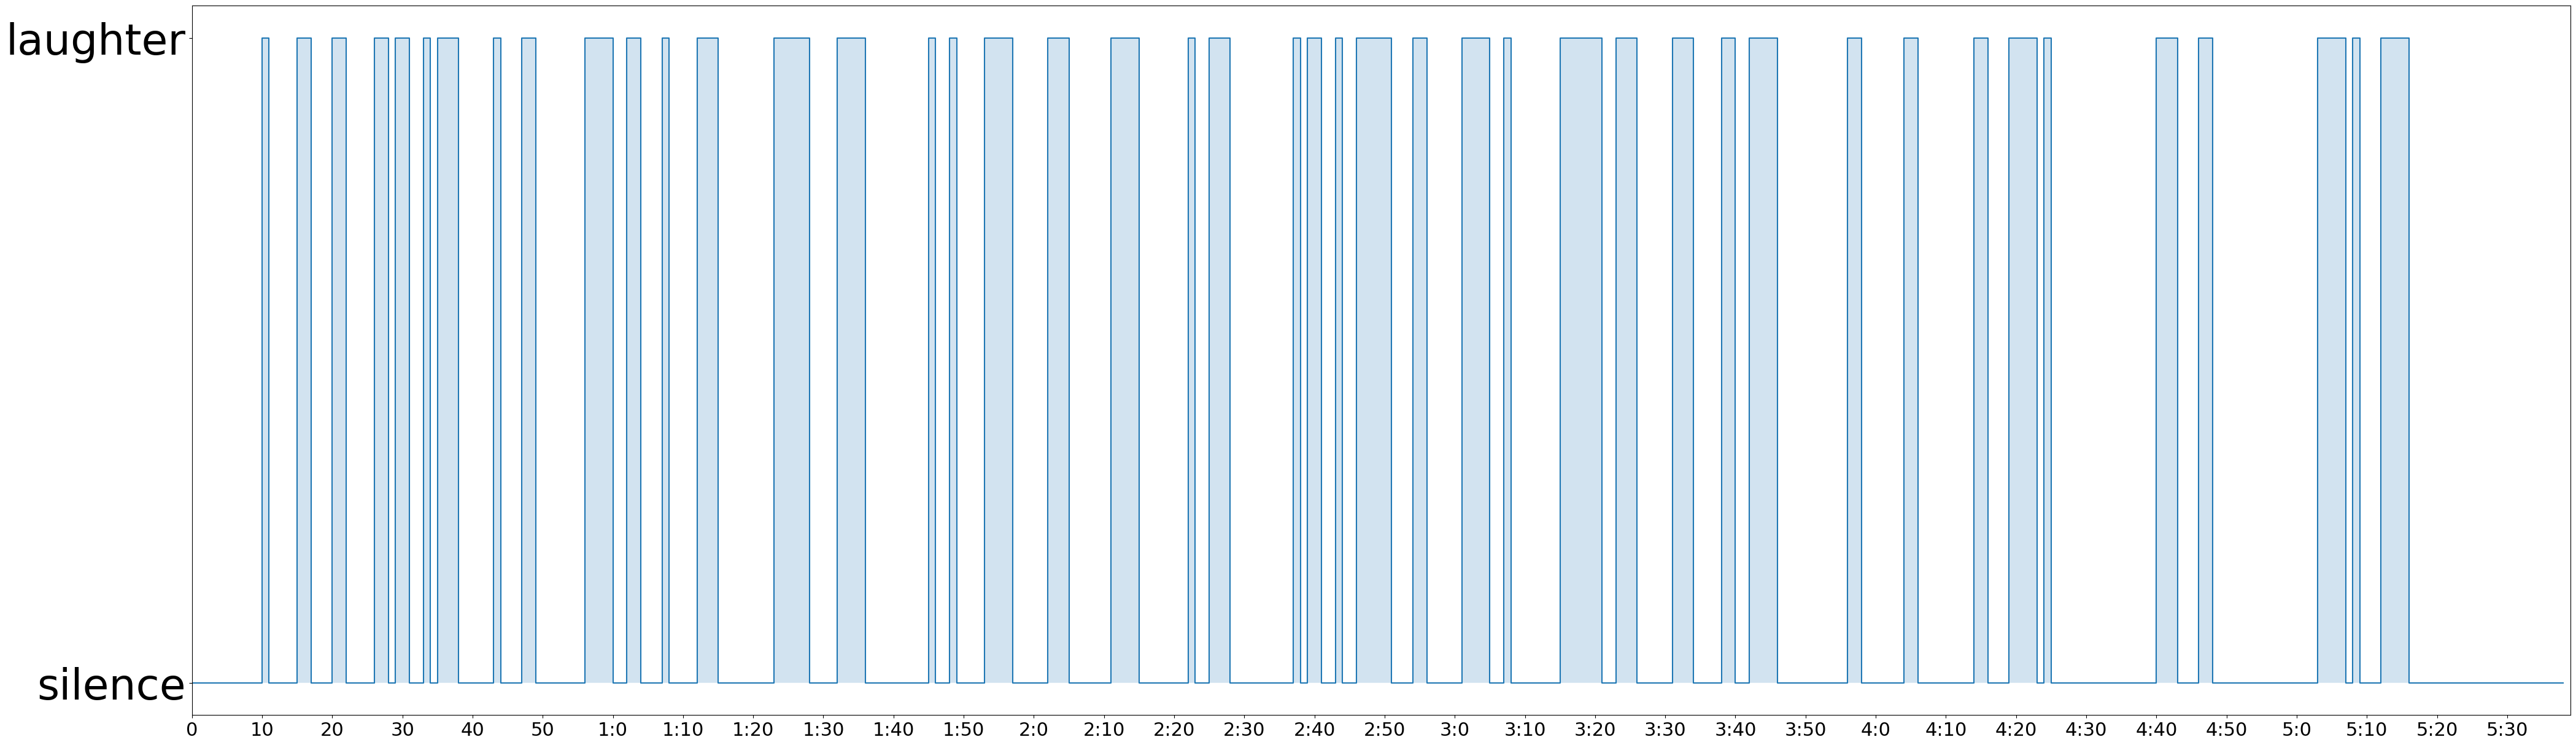

In [119]:
plt.rcParams["figure.figsize"] = (50,15)
x_axis = []
y_axis = []
for i in range(y_guess.size):
  minutes = str(np.floor_divide(i, 60))
  seconds = str(np.mod(i, 60))
  if minutes=='0':
    x_axis.append('' + seconds)
  else:
    x_axis.append('' + minutes + ':' + seconds) 
  if y_guess[i]==0:
    y_axis.append('silence')
  else:
    y_axis.append('laughter')

fig, ax = plt.subplots()
ax.step(x_axis, y_axis)

plt.xlim([0, y_guess.shape[0]]);
plt.ylim([-.05,1.05]);
plt.yticks(fontsize=50);
plt.xticks(fontsize=22)
plt.xticks(np.arange(0, y_guess.shape[0], 10)); 
plt.fill_between(x_axis, y_axis, step="pre", alpha=0.2)
